In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-2-d3e41175beee>:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.63938715e-06 8.19380135e-02 2.28917924e-02 2.02579452e-05
 0.00000000e+00 1.89198050e-02 3.45514997e-04 1.17763577e-02
 3.19765660e-02 2.29739624e-02 6.18773109e-04 4.09700467e-06
 7.10060725e-06 6.62835310e-02 1.13561226e-02 1.12936663e-02
 2.43328373e-02 9.16553092e-03 4.32959255e-02 2.38936324e-03
 0.00000000e+00 2.95740937e-03 3.26420469e-02 2.33325404e-03
 6.33596599e-02 1.92392657e-02 7.44073121e-04 9.49577924e-02
 9.37239636e-03 9.15304597e-04 2.01569511e-02 1.04548696e-03
 5.39623934e-06 6.67638624e-02 9.84481009e-05 1.80782334e-01
 3.30613204e-04 1.02455113e-03 1.05661020e-03 1.42623688e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_vector.update(norm_imp)
<ipython-input-2-d3e41175beee>:72: FutureWarning: Setting an item of incompatible dtype is deprecated and 

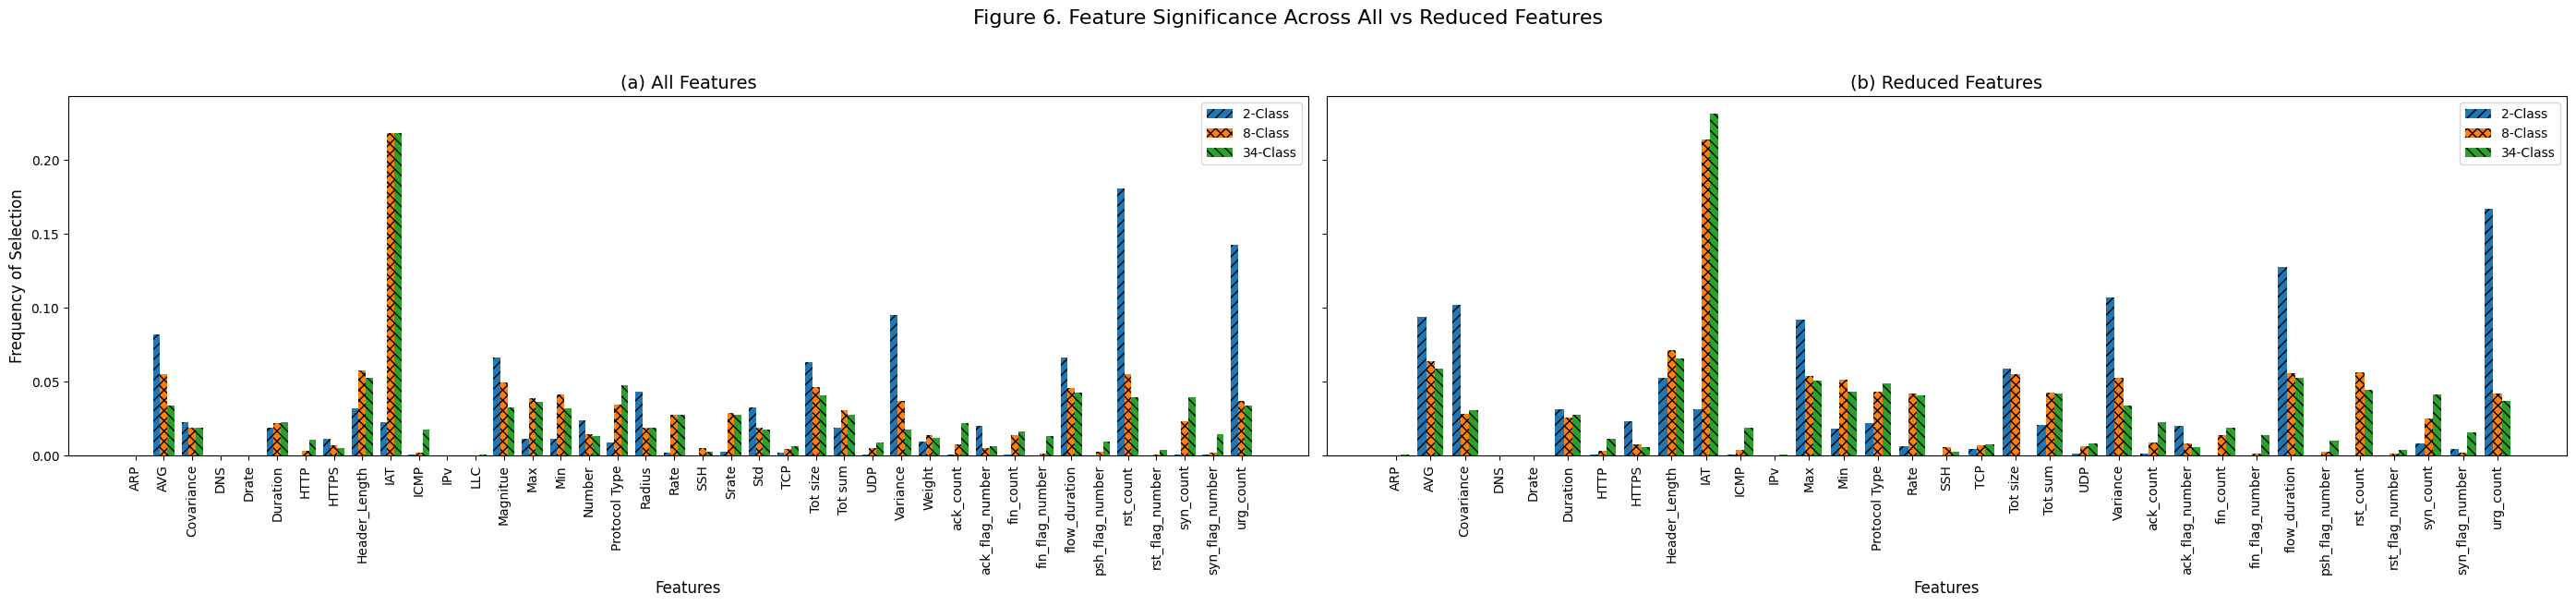

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# File paths
full_paths = {
    "2-Class": ["/content/drive/MyDrive/CICIoT2023/2class/part.0.parquet"],
    "8-Class": [
        "/content/drive/MyDrive/CICIoT2023/8class/part.0.parquet",
        "/content/drive/MyDrive/CICIoT2023/8class/part.1.parquet",
        "/content/drive/MyDrive/CICIoT2023/8class/part.2.parquet",
        "/content/drive/MyDrive/CICIoT2023/8class/part.3.parquet"
    ],
    "34-Class": [
        "/content/drive/MyDrive/CICIoT2023/34class/part.0.parquet",
        "/content/drive/MyDrive/CICIoT2023/34class/part.1.parquet",
        "/content/drive/MyDrive/CICIoT2023/34class/part.2.parquet",
        "/content/drive/MyDrive/CICIoT2023/34class/part.3.parquet"
    ]
}

reduced_paths = {
    "2-Class": "/content/drive/MyDrive/CICIoT2023/Feature_Reduced/2class_reduced.parquet",
    "8-Class": "/content/drive/MyDrive/CICIoT2023/Feature_Reduced/8class_reduced.parquet",
    "34-Class": "/content/drive/MyDrive/CICIoT2023/Feature_Reduced/34class_reduced.parquet"
}

def compute_importance(paths, is_reduced=False):
    importance_df = pd.DataFrame()
    for name, path_list in paths.items():
        print(f"Processing: {name} ({'Reduced' if is_reduced else 'Full'})")

        # Load data
        if isinstance(path_list, list):
            df = pd.concat([pd.read_parquet(p) for p in path_list], ignore_index=True)
        else:
            df = pd.read_parquet(path_list)

        X = df.drop("label", axis=1)
        y = df["label"]

        # Encode and scale
        y_enc = LabelEncoder().fit_transform(y)
        X_scaled = StandardScaler().fit_transform(X)

        # Split
        X_train, _, y_train, _ = train_test_split(
            X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=42
        )

        # Train RF
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)

        importances = rf.feature_importances_
        normalized = importances / importances.sum()
        importance_df[name] = pd.Series(normalized, index=X.columns)

    return importance_df

# Compute importances
importance_full = compute_importance(full_paths, is_reduced=False)
importance_reduced = compute_importance(reduced_paths, is_reduced=True)

# --- Plotting side-by-side ---

fig, axes = plt.subplots(1, 2, figsize=(28, 7), sharey=True)

# Part (a) - All features
x1 = np.arange(len(importance_full))
w = 0.25
axes[0].bar(x1 - w, importance_full["2-Class"], width=w, label="2-Class", hatch='///')
axes[0].bar(x1, importance_full["8-Class"], width=w, label="8-Class", hatch='xxx')
axes[0].bar(x1 + w, importance_full["34-Class"], width=w, label="34-Class", hatch='\\\\\\')
axes[0].set_title("(a) All Features", fontsize=14)
axes[0].set_xlabel("Features", fontsize=12)
axes[0].set_ylabel("Frequency of Selection", fontsize=12)
axes[0].set_xticks(x1)
axes[0].set_xticklabels(importance_full.index, rotation=90)
axes[0].legend()

# Part (b) - Reduced features
x2 = np.arange(len(importance_reduced))
axes[1].bar(x2 - w, importance_reduced["2-Class"], width=w, label="2-Class", hatch='///')
axes[1].bar(x2, importance_reduced["8-Class"], width=w, label="8-Class", hatch='xxx')
axes[1].bar(x2 + w, importance_reduced["34-Class"], width=w, label="34-Class", hatch='\\\\\\')
axes[1].set_title("(b) Reduced Features", fontsize=14)
axes[1].set_xlabel("Features", fontsize=12)
axes[1].set_xticks(x2)
axes[1].set_xticklabels(importance_reduced.index, rotation=90)
axes[1].legend()

plt.suptitle("Figure 6. Feature Significance Across All vs Reduced Features", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


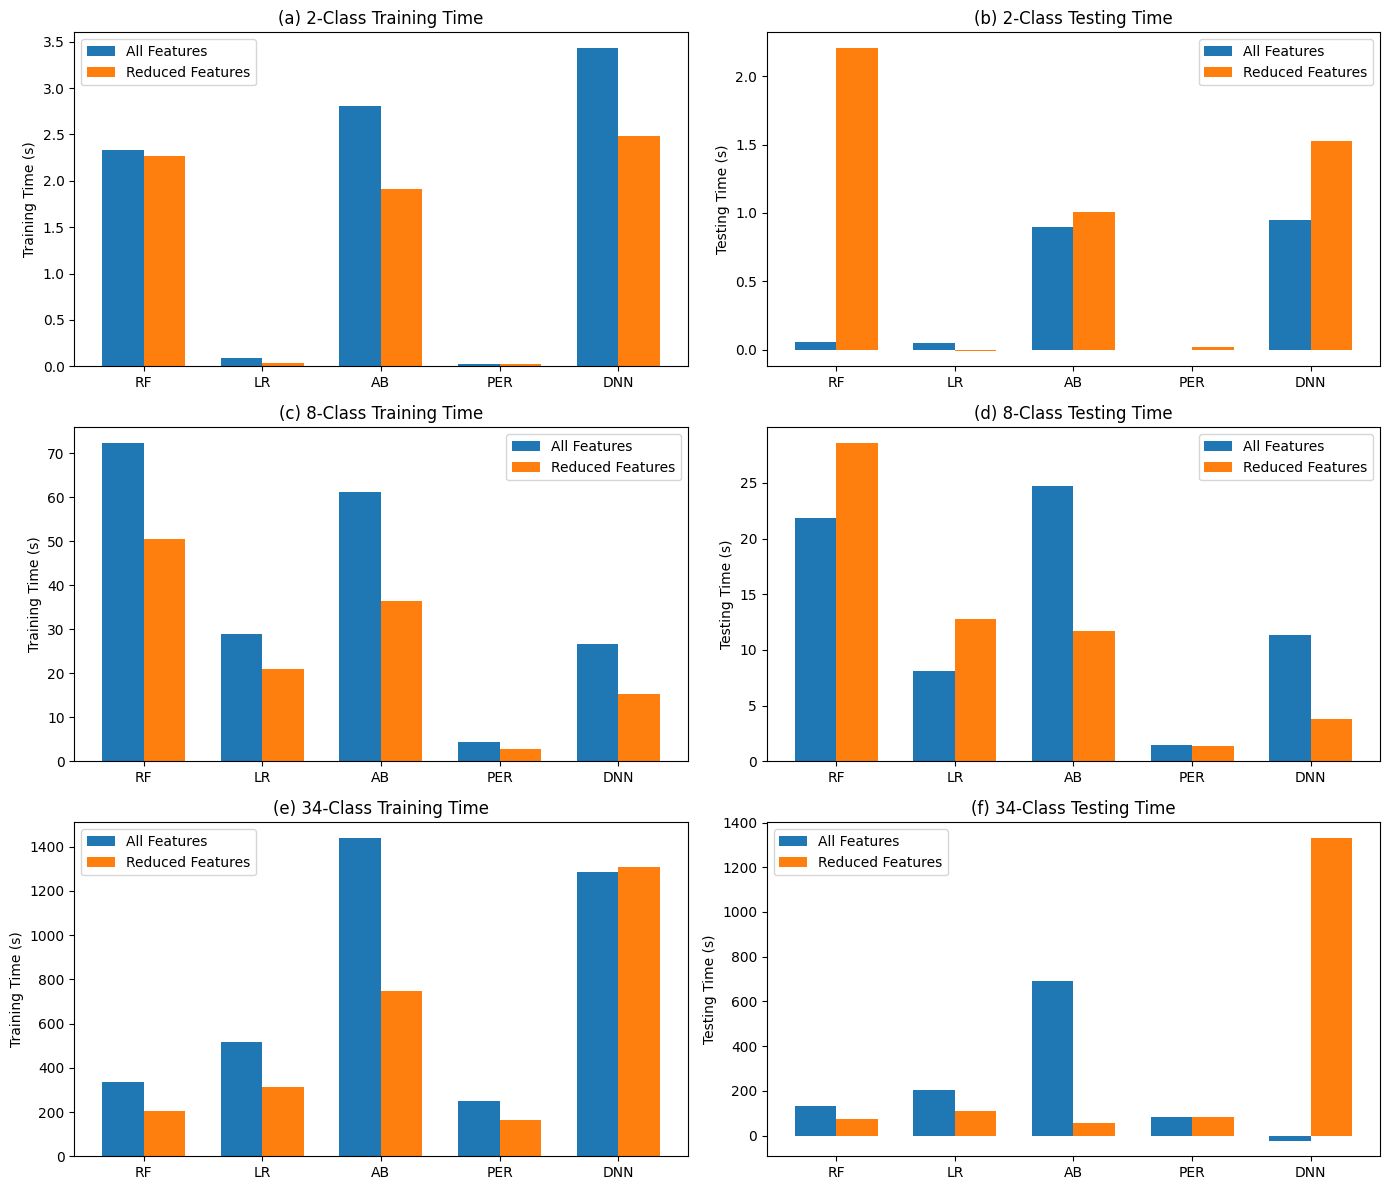

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and models
models = ["RF", "LR", "AB", "PER", "DNN"]
x = np.arange(len(models))
width = 0.35

# Timing data in seconds (from your input)
train_times_all = {
    "2-Class": [2.33, 0.09, 2.81, 0.02, 3.43],
    "8-Class": [72.27, 28.94, 61.26, 4.38, 26.56],
    "34-Class": [337.27, 517.50, 1438.07, 249.75, 1284.02]
}

train_times_reduced = {
    "2-Class": [2.27, 0.04, 1.91, 0.02, 2.48],
    "8-Class": [50.42, 20.86, 36.50, 2.88, 15.20],
    "34-Class": [206.45, 313.06, 747.80, 166.17, 1308.47]
}

# Derive test times from difference
test_times_all = {
    k: [a - b for a, b in zip(train_times_all[k], train_times_reduced[k])]
    for k in train_times_all
}

test_times_reduced = {
    k: [b - (a - b) for a, b in zip(train_times_all[k], train_times_reduced[k])]
    for k in train_times_all
}

# Titles and class names
titles = [
    "(a) 2-Class Training Time", "(b) 2-Class Testing Time",
    "(c) 8-Class Training Time", "(d) 8-Class Testing Time",
    "(e) 34-Class Training Time", "(f) 34-Class Testing Time"
]

class_names = ["2-Class", "8-Class", "34-Class"]

# 🎨 Color settings
color_all = "#1f77b4"     # Blue
color_reduced = "#ff7f0e" # Orange

# Plot
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i, class_name in enumerate(class_names):
    # Training plot
    ax_train = axes[i][0]
    ax_train.bar(x - width/2, train_times_all[class_name], width, label="All Features", color=color_all)
    ax_train.bar(x + width/2, train_times_reduced[class_name], width, label="Reduced Features", color=color_reduced)
    ax_train.set_title(titles[i*2])
    ax_train.set_ylabel("Training Time (s)")
    ax_train.set_xticks(x)
    ax_train.set_xticklabels(models)
    ax_train.legend()

    # Testing plot
    ax_test = axes[i][1]
    ax_test.bar(x - width/2, test_times_all[class_name], width, label="All Features", color=color_all)
    ax_test.bar(x + width/2, test_times_reduced[class_name], width, label="Reduced Features", color=color_reduced)
    ax_test.set_title(titles[i*2 + 1])
    ax_test.set_ylabel("Testing Time (s)")
    ax_test.set_xticks(x)
    ax_test.set_xticklabels(models)
    ax_test.legend()

plt.tight_layout()
plt.show()
